In [464]:
import cv2
import torch
import random
import copy
import time

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from math import cos,sin,pi
from PIL import Image
from PIL import ImageChops

## Data Preprocessing

新增部分  
1. 扩大脸部范围后，关键点超出边界范围再处理
2. 数据组分为训练集、验证集、测试集

In [221]:
floder_path = ['./项目二/data/I/', './项目二/data/II/']

def creat_data(floder_path):
    data = {'train':[], 'valid':[], 'test':[]}
    
#     f1 = open('train.csv','w',newline='',encoding='utf-8-sig')
#     f2 = open('test.csv','w',newline='',encoding='utf-8-sig')
#     f3 = open('valid.csv','w',newline='',encoding='utf-8-sig')
#     train = csv.writer(f1)
#     test = csv.writer(f2)
#     valid = csv.write(f3)
    
    error = 0
    error_lst = []
    for url in floder_path:
        with open((url + 'label.txt')) as f:
            lines = f.readlines()

            for line in lines:
                line = line.split()
                assert len(line) == 47, 'data error'

                line[0] = url + line[0]
                line[1: 5] = expand_roi(line[1: 5], 0.25, line[0])
                line[5:] = np.array([float(i) for i in line[5:]]).reshape(-1, 2)
                
                # 扩大后点边界范围
                x_limit1, y_limit1, x_limit2, y_limit2 = line[1: 5]
                x1, y1, x2, y2 = line[1: 5]
                for i, j in line[5:]:
                    if i > x_limit2 or i < x_limit1 or j < y_limit1 or j > y_limit2:
                        error += 1
                        error_lst.append(line)
                        break
                else:
                    p = random.uniform(0, 1)

                    if p > 0.3:
                        data['train'].append(line)
#                         train.writerow(line)
                    elif 0.1 < p < 0.3:
                        data['valid'].append(line)
#                         valid.writerow(line)
                    else:
                        data['test'].append(line)
#                         test.writerow(line)

    train_nums = len(data['train'])
    valid_nums = len(data['valid'])
    test_nums = len(data['test'])
    
#     f1.close()
#     f2.close()
#     f3.close()
    
    print(f'Train: {train_nums}, Valid: {valid_nums}, Test: {test_nums}')
    
    return data, error_lst

# 脸部范围扩大

def expand_roi(face_list, ratio, img_url):
    img = cv2.imread(img_url)
    img_height, img_width, _ = img.shape
    x1, y1, x2, y2 = [int(float(i)) for i in face_list]
    
    width = x2 - x1 + 1
    height = y2 - y1 + 1
    padding_width = int(width * ratio)
    padding_height = int(height * ratio)
    
    roi_x1 = x1 - padding_width
    roi_y1 = y1 - padding_height
    roi_x2 = x2 + padding_width
    roi_y2 = y2 + padding_height
    roi_x1 = 0 if roi_x1 < 0 else roi_x1
    roi_y1 = 0 if roi_y1 < 0 else roi_y1
    roi_x2 = img_width - 1 if roi_x2 >= img_width else roi_x2
    roi_y2 = img_height - 1 if roi_y2 >= img_height else roi_y2
    
    return [roi_x1, roi_y1, roi_x2, roi_y2]

data, error_lst = creat_data(floder_path)

Train: 1932, Valid: 537, Test: 248


#### *看一下有问题的数据集

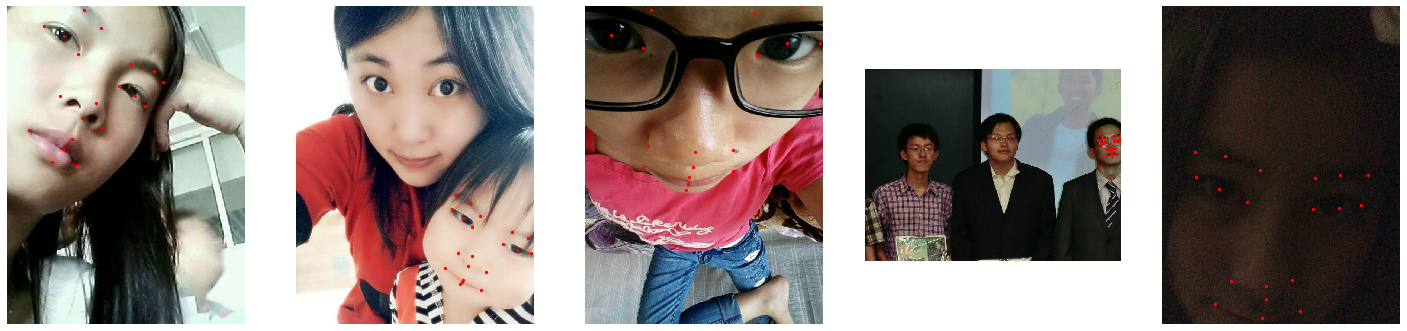

In [226]:
def my_show(data, nums):
    fig = plt.figure(figsize=(20, 5))
    lst = []
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(0, 68)
        lst.append(n)
        line = data[n]
        img = np.array(Image.open(line[0]))
        landmarks = np.array(line[5:])
  
        X = landmarks[:, 0]
        Y = landmarks[:, 1]
        ax.scatter(X, Y, s=20, marker='.', c='r')
        ax.imshow(img)
        ax.axis('off')
        
my_show(error_lst, 5)

## Dataset
新增部分
1. 增加了数据增强（旋转、平移、镜像）

In [397]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, data, transform=None):
        self.lines = data
        self.transform = transform
        
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        line = self.lines[idx]
        img_name, rect, landmarks = line[0], line[1: 5], line[5:]
        
        # 人脸范围剪裁
        img = Image.open(img_name).convert('RGB')
        image = img.crop(rect)

        # 标准化标记点
        landmarks = np.asarray(landmarks, dtype=np.float32).reshape(-1, 2)
        landmarks -= rect[:2]
        
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    


#### 随机旋转

In [398]:
class Random_Rotate:
    
    def __init__(self, angle_limit):
        self.angle = angle_limit
    
    def rotate(self, pst, angle, cx, cy):
        """
        点(x,y) 绕(cx,cy)点旋转
        """
        x, y = pst
        angle = -(angle*pi/180)
        x_new = (x-cx)*cos(angle) - (y-cy)*sin(angle) + cx
        y_new = (x-cx)*sin(angle) + (y-cy)*cos(angle) + cy
        return x_new,y_new
    
    
    def __call__(self, sample):
        """
        注意：
        1, 如果以下形式调用，angle会传入两次不一样的random值
        input_img = batch['image']
        target_pts = batch['landmarks']
        """
        image, landmarks = sample.values()
        # 随机角度
        while True:
            n = random.uniform(0, 1)
            if n < 0.5:
                return {'image': image, 'landmarks': landmarks}
            
            angle = random.randint(-self.angle, self.angle)
            h, w = np.array(image).shape[:2]

            img = image.rotate(angle, Image.BILINEAR)
            
#             Image.BICUBIC
            lan = np.array([self.rotate(point, angle, w/2, h/2) for point in landmarks])
            
            for i, j in lan:
                if i > w or i < 0 or j < 0 or j > h:
                    break
            else:
                return {'image': img, 'landmarks': lan}
            


#### 随机镜像

In [399]:
class Random_HorizontalFlip:
    def __call__(self, sample):
        image, landmarks = sample.values()
        pred = random.uniform(0, 1)
        if pred < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            h, w = np.array(image).shape[:2]
            landmarks[:, 0] += w - landmarks[:, 0] * 2
        
        return {'image': image, 'landmarks': landmarks}
    
    

#### 随机平移

In [400]:
class Random_Move:
    
    def __init__(self, dis):
        self.dis = dis
    
    def __call__(self, sample):
        image, landmarks = sample.values()
        while True:
            n = random.uniform(0, 1)
            if n < 0.5:
                return {'image': image , 'landmarks': landmarks}

            h, w = np.array(image).shape[:2]
            x = random.randint(-self.dis, self.dis)
            y = random.randint(-self.dis, self.dis)
            img = ImageChops.offset(image, x, y)
            lan = landmarks + [x, y]

            for i, j in lan:
                if i > w or i < 0 or j < 0 or j > h:
                    break
            else:
                return {'image': img, 'landmarks': lan}
        
        

In [409]:
class Crop_Risize:
    def __call__(self, sample, train_boarder=112):
        image, landmarks = sample.values()

        image_width, image_height = image.size
        image = image.resize((train_boarder, train_boarder),Image.BILINEAR)  # Image.ANTIALIAS
#         image = np.asarray(image, dtype=np.float32)
        # 标准化landmarks
        landmarks[:, 0] = landmarks[:, 0] * train_boarder / image_width
        landmarks[:, 1] = landmarks[:, 1] * train_boarder / image_height
        
        return {'image': image, 'landmarks': landmarks}

class Normalize:
    def __call__(self, sample):
        image, landmarks = sample.values()
        
        n = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = n(image)
        

        return {'image': image, 'landmarks': landmarks}

class ToTensor:
    def __call__(self, sample):
        image, landmarks = sample.values()
            
#         image = image.transpose((2, 0, 1))
#         image = torch.from_numpy(image).float()
#         landmarks = landmarks.ravel()
#         landmarks = torch.from_numpy(landmarks).float()
        t = transforms.ToTensor()
        image = t(image)
        landmarks = landmarks.ravel()
        landmarks = torch.from_numpy(landmarks).float()

        return {'image': image, 'landmarks': landmarks}

[669, 777, 1031, 61, 728]


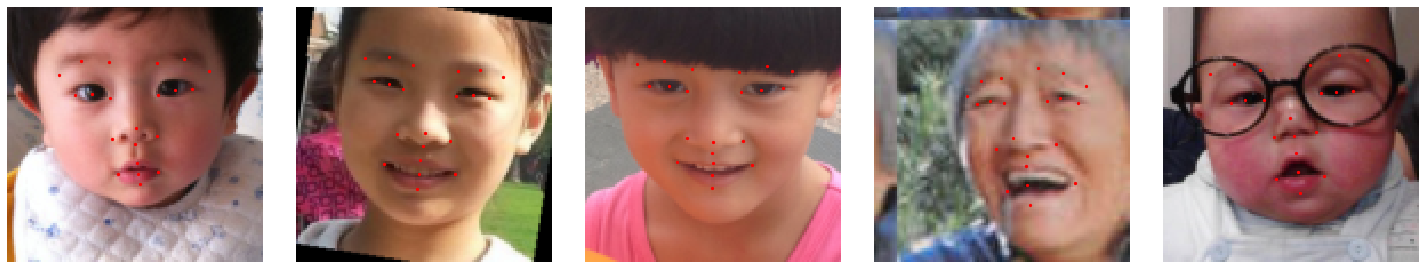

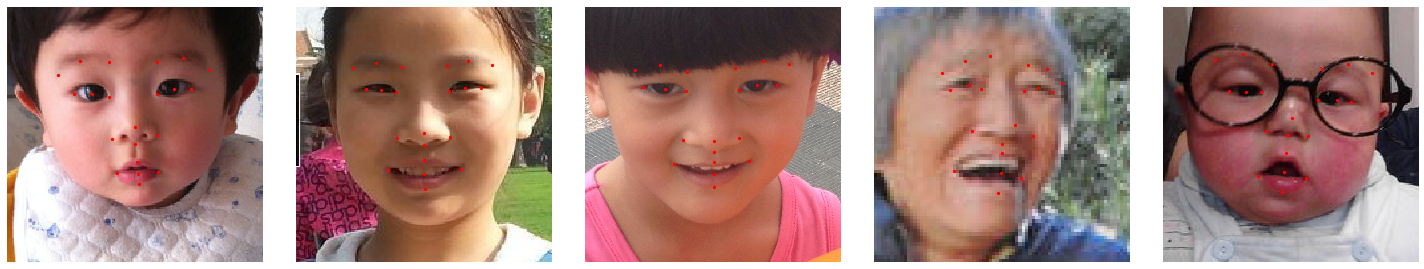

In [419]:
# 数据可视化展示

def my_show(data, data2, nums):
    fig = plt.figure(figsize=(20, 5))
    lst = []
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(1, 1200)
        lst.append(n)
        image, landmarks = data[n].values()
        image = image.numpy().transpose((1, 2, 0))
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = std * image + mean
        image = np.clip(image, 0, 1)
        landmarks = landmarks.numpy()
        
        X = landmarks[0::2]
        Y = landmarks[1::2]
        ax.scatter(X, Y, s=20, marker='.', c='r')
        ax.imshow(image)
        ax.axis('off')
    print(lst)
    fig = plt.figure(figsize=(20, 5))
    for i in range(len(lst)):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(1, 1200)
        lst.append(n)
        img, landmarks = data2[lst[i]].values()
        
        X = landmarks[:, 0]
        Y = landmarks[:, 1]
        ax.scatter(X, Y, s=20, marker='.', c='r')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        
trfm = transforms.Compose([Random_HorizontalFlip(),
                           Random_Rotate(20), 
                           Random_Move(10), 
                           Crop_Risize(), ToTensor(), Normalize()
                          ])

img_show = FaceLandmarksDataset(data['train'], transform=trfm)
img_ori = FaceLandmarksDataset(data['train'])
my_show(img_show,img_ori, 5)

## Model
新增部分
1. 网络加深、加宽、加了BN
2. 测试了几个不同的模型提取特征（resnet、vgg等）

#### 自定义模型

In [420]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # in_channel, out_channel, kernel_size, stride, padding
        self.conv1_1 = nn.Conv2d(3, 8, 5, 2, 0)
        
        self.conv2_1 = nn.Conv2d(8, 32, 3, 1, 0)
        self.conv2_2 = nn.Conv2d(32, 32, 3, 1, 0)
        
        self.conv3_1 = nn.Conv2d(32, 128, 3, 1, 0)
        self.conv3_2 = nn.Conv2d(128, 128, 3, 1, 0)
        
        self.conv4_1 = nn.Conv2d(128, 512, 3, 1, 1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1, 1)
        
        self.conv5_1 = nn.Conv2d(512, 256, 3, 1, 1)
        self.conv5_2 = nn.Conv2d(256, 256, 3, 1, 1)
        
        self.conv6_1 = nn.Conv2d(256, 128, 3, 1, 1)
        self.conv6_2 = nn.Conv2d(128, 128, 3, 1, 1)
        
        self.ip1 = nn.Linear(8 * 8 * 128, 128)
        self.ip2 = nn.Linear(128, 128)
        self.ip3 = nn.Linear(128, 42)
        
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.prelu = nn.PReLU()
        
        self.ave_pool = nn.AvgPool2d(2, 2, ceil_mode=True)
        
    def forward(self, x):
        x = self.ave_pool(self.bn1(self.prelu(self.conv1_1(x))))
                                    # in：32*3*112*112  out：32*8*27*27
                                    # conv: (112 - 5) // 2 + 1 = 54  pooling: 52 / 2 = 27
        x = self.bn2(self.prelu(self.conv2_1(x)))
                                    # out: 32*16*25*25
        x = self.bn2(self.prelu(self.conv2_2(x)))
                                    # out: 32*16*23*23
        x = self.ave_pool(x)
                                    # out: 32*16*12*12
        x = self.bn3(self.prelu(self.conv3_1(x)))
                                    # out: 32*24*10*10
        x = self.bn3(self.prelu(self.conv3_2(x)))
                                    # out: 32*24*8*8
#         x = self.ave_pool(x)
                                    # out: 32*24*4*4
        x = self.bn4(self.prelu(self.conv4_1(x)))
                                    # out: 32*40*4*4
        # stage 3 branch
        x = self.bn4(self.prelu(self.conv4_2(x)))
                                    # out: 32*80*4*4
        x = self.bn5(self.prelu(self.conv5_1(x))) 
        x = self.bn5(self.prelu(self.conv5_2(x))) 
        x = self.bn6(self.prelu(self.conv6_1(x)))
        x = self.bn6(self.prelu(self.conv6_2(x)))
         
        # FC
        x = x.view(-1, 8 * 8 * 128)
                                    # out: 32*1280
        ip1 = self.prelu(self.ip1(x))
                                    # out: 32*128
        ip2 = self.prelu(self.ip2(ip1))
                                    # out: 32*128
        ip3 = self.prelu(self.ip3(ip2))
                                    # out: 32*42   (21组坐标点)
        return ip3

net_custom = Net()

#### Resnet_18

In [421]:
from torchvision import models
net_resnet18 = models.resnet18(pretrained=True)

for param in net_resnet18.parameters():
    param.requires_grad = False
    
num_ftrs = net_resnet18.fc.in_features
net_resnet18.fc = nn.Linear(num_ftrs, 42)

#### Vgg_16

In [422]:
net_vgg16 = models.vgg16(pretrained=True).to(device)

for param in net_vgg16.parameters():
    param.requires_grad = False

num_ftrs = net_vgg16.classifier[6].in_features
net_vgg16.classifier[6] = nn.Linear(num_ftrs, 42)

## Training

新增部分：
1. 保留最好模型

In [487]:
# 训练模型

def train(train_loader, valid_loader, model, criterion, optimizer, epoch, scheduler=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_valid_loss = float('inf')
    
    for epoch_idx in range(epoch):
        # Training the model
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            image, landmarks = batch.values()
            input_img = image.to(device)
            target_pts = landmarks.to(device)
            
            optimizer.zero_grad()
            output_pts = model(input_img)
            loss = criterion(output_pts, target_pts)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        train_loss /= len(iter(train_loader))
        if epoch_idx % 50 == 0:
            print('Train Epoch: {}, pts_loss: {:.4f}'.format(epoch_idx + 1, train_loss))
        
#       Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_loss = 0.0

            for valid_batch_idx, batch in enumerate(valid_loader):
                image, landmarks = batch.values()
    
                input_img = image.to(device)
                target_pts = landmarks.to(device)
                
                output_pts = model(input_img)
                valid_loss = criterion(output_pts, target_pts)
                
                val_loss += valid_loss.item()

        val_loss /= len(iter(valid_loader))

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if epoch_idx % 50 == 0:
            print('Valid Epoch: {}, pts_loss: {:.4f}'.format(epoch_idx + 1, val_loss))
            print('-' * 50)
#         更新lr
        if scheduler:
            scheduler.step()

#     保存模型
    model.load_state_dict(best_model_wts)
    time_elapesd = time.time() - since
        
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapesd // 60, time_elapesd % 60))
    print('Best val loss: {:4f}'.format(best_valid_loss))
    return model




In [488]:
# 超参数调整
lr = 0.001
batch_size = 64
momentum = 0.9
epoch = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Transform
trfm = transforms.Compose([
    Random_HorizontalFlip() ,
    Random_Rotate(20), 
    Random_Move(10), 
    Crop_Risize(), ToTensor(), Normalize()])
trfm_test = transforms.Compose([Crop_Risize(), ToTensor(), Normalize()])

# Dataset
train_set = FaceLandmarksDataset(data['train'], transform=trfm)
valid_set = FaceLandmarksDataset(data['valid'], transform=trfm_test)
test_set = FaceLandmarksDataset(data['test'], transform=trfm_test)

# DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)


In [ ]:
model = net_custom.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model_custom = train(train_loader, valid_loader, model, criterion, optimizer, epoch)
torch.save(model_custom, './model_custom.pth')


Train Epoch: 1, pts_loss: 199.3712
Valid Epoch: 1, pts_loss: 290.9785
--------------------------------------------------
Train Epoch: 51, pts_loss: 129.3884
Valid Epoch: 51, pts_loss: 151.9449
--------------------------------------------------
Train Epoch: 101, pts_loss: 83.5628
Valid Epoch: 101, pts_loss: 66.5811
--------------------------------------------------
Train Epoch: 151, pts_loss: 35.6206
Valid Epoch: 151, pts_loss: 59.4452
--------------------------------------------------
Train Epoch: 201, pts_loss: 29.5456
Valid Epoch: 201, pts_loss: 44.1811
--------------------------------------------------
Train Epoch: 251, pts_loss: 19.9311
Valid Epoch: 251, pts_loss: 42.6865
--------------------------------------------------


In [ ]:
model = net_resnet18.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model_resnet18 = train(train_loader, valid_loader, model, criterion, optimizer, epoch)
torch.save(model_resnet18, './model_resnet18.pth')



In [ ]:
model = net_vgg16.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model_vgg16 = train(train_loader, valid_loader, model, criterion, optimizer, epoch)
torch.save(model_vgg16, './model_vgg16.pth')


## Visualize

In [ ]:
def Visualize(model_url):
    test_model = torch.load(model_url)
    test_model.eval()
    
    loss_totle = 0.0
    
    with torch.no_grad():
        for test in test_loader:
            image, landmarks = test.values()

            outputs = test_model(image)
            loss = criterion(outputs, landmarks)
            loss_totle += loss
            break
        print('loss_totle: {:.4f}'.format(loss_totle.item()/batch_size))

    fig = plt.figure(figsize=(20, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.tight_layout()

        n = random.randint(0, batch_size)

        img = image[n].numpy().transpose((1, 2, 0))
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = std * img + mean
        img = np.clip(img, 0, 1)
        lan = outputs[n].numpy().reshape(-1, 2)
     
        ax.scatter(lan[:, 0], lan[:, 1], s=20, marker='.', c='r')
        ax.imshow(img)
        ax.axis('off')

In [ ]:
Visualize('./model_custom.pth')

In [ ]:
Visualize('./model_resnet18.pth')

In [ ]:
Visualize('./model_vgg16.pth')